<a href="https://colab.research.google.com/github/SimoneCallegarin/NLP_project/blob/main/SA_and_TextGen_on_EDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

## **Libraries Imports**

In [1]:
%%capture
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
from sklearn import metrics
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.models import CoherenceModel
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline
fig, ax = plt.subplots(figsize=(14, 5))

A function for printing graphs in a formatted way

In [2]:
def print_graph(title, xlab, ylab, rotated):
    plt.title(title)
    plt.ylabel(ylab, fontsize=12)
    plt.xlabel(xlab, fontsize=12)
    if rotated:
        plt.xticks(rotation=90)

## **Dataset Download**

In [3]:
csv_path = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/EDOS_1M.csv"

# **Dataset Import and Cleaning**

We will now import the EDOS dataset and clean it from:
    
- duplicates
- null values

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


In [6]:
df.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


In [7]:
df.duplicated().sum()

0

In [8]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return None
    else:
        return s

In [9]:
df['uttr'].apply(lambda s: isEnglish(s)).size  #same size as before, no rows were removed 

2829426

As we can see the dataset was already cleaned since we have no duplicated, null rows or not-ASCII characters (which usually means we are dealing with a multilingual dataset), so we can proceed to the next steps without worries.

# **Preliminary Analysis**

## **EDA - Exploratory Data Analysis**

Before diving into the training and evaluation of many different NLP models, we will perform the EDA (Exploratory Data Analysis) to have basic but fundamental insights about the data.

In particular we will get:

- basic informations about the dataset
- some descriptive statistics

### **Basic Understanding of the Dataset**

As stated on the dataset website, EDOS contains short phrases (from 3 to 5 utterances), each labeled with an emotion. Let's get a better look at them

In [86]:
print([x for x in df['uttr'][0:5]])

['You moron ! What fool washes diapers by the well !', 'You useless fool !', 'How dare you sleep !', 'Up ! Go and clean the house .', 'Clean the kitchen .']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's now check all the possible values of the emotion type, which will be our target in case of sentiment analysis

In [10]:
emotions = df['eb+_emot'].unique()
print(emotions)

['angry' 'furious' 'prepared' 'acknowledging' 'trusting' 'confident'
 'hopeful' 'caring' 'sentimental' 'anticipating' 'wishing' 'surprised'
 'ashamed' 'questioning' 'sad' 'nostalgic' 'devastated' 'terrified'
 'embarrassed' 'lonely' 'encouraging' 'suggesting' 'content' 'afraid'
 'impressed' 'agreeing' 'apprehensive' 'proud' 'annoyed' 'anxious'
 'grateful' 'excited' 'neutral' 'faithful' 'guilty' 'consoling'
 'disgusted' 'disappointed' 'jealous' 'joyful' 'sympathizing']


With all these possible emotions to predict, it's very probable that we will have to deal with unbalanced classes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


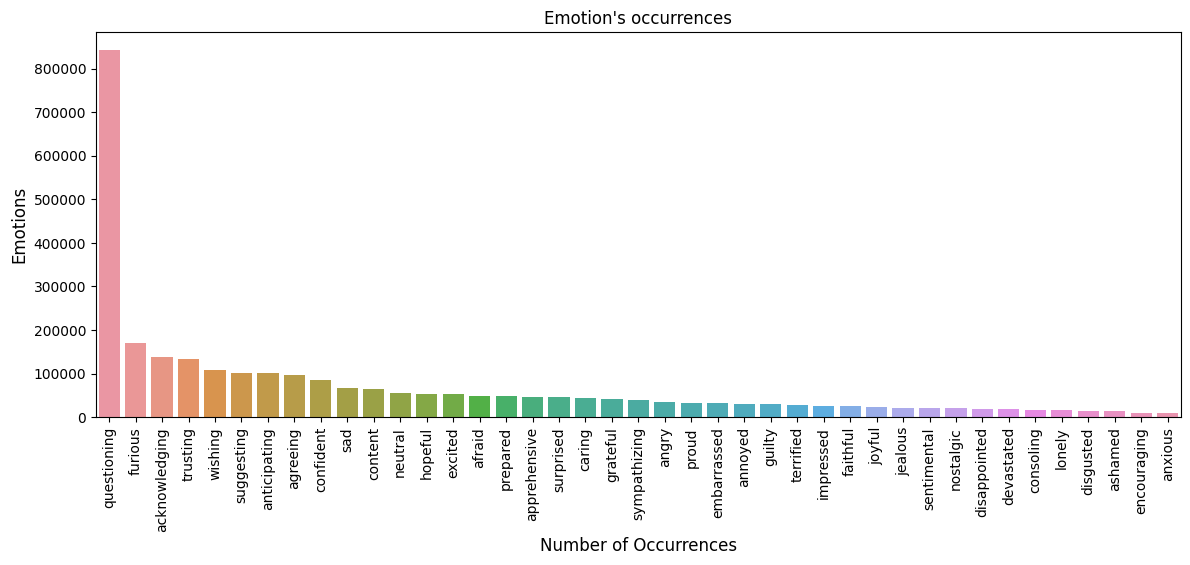

In [88]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(data=df, x='eb+_emot', order=df['eb+_emot'].value_counts().index, ax=ax)
print_graph('Emotion\'s occurrences', 'Number of Occurrences', 'Emotions', True)

In [89]:
df['eb+_emot'].value_counts()[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
Name: eb+_emot, dtype: int64

As we can see, we have quite an unbalancing here with the 'questioning' texts being over 800k while all the others stay under 200k.

We will have to deal with it in the next phases when we will have to train models on this dataset

### **Descriptive Statistics**

We will use some text visualization techniques for better and instant insights about:

- text lengths distribution
- word number distribution

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


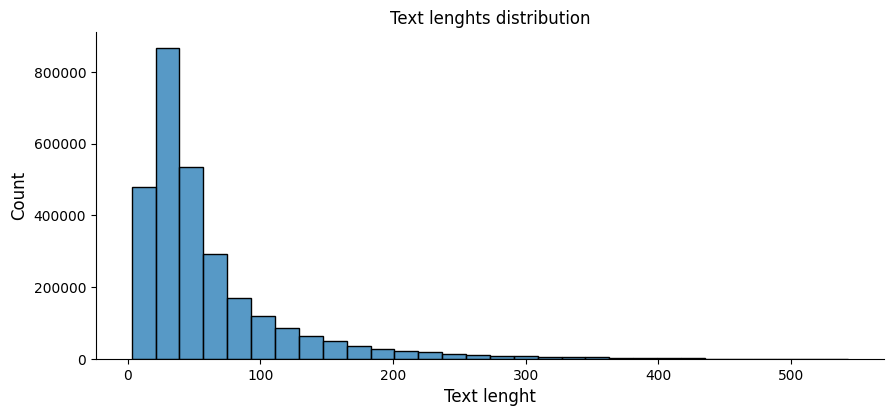

In [90]:
sns.displot(df['uttr'].str.len(), kde = False, bins = 30, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


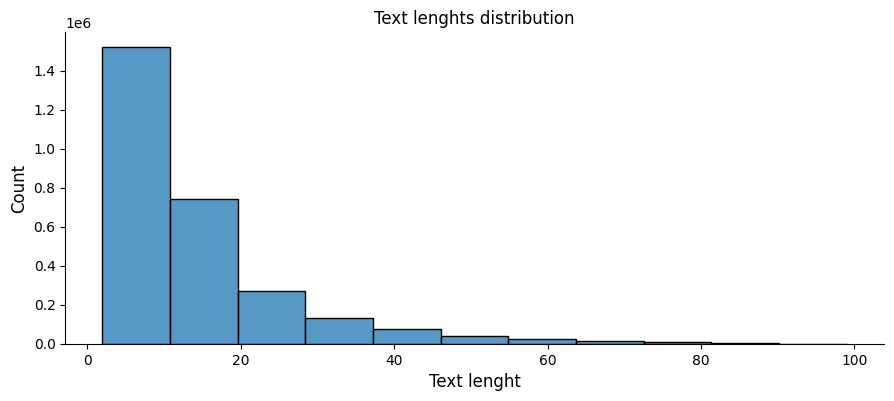

In [91]:
sns.displot(df['uttr'].str.split().map(lambda x: len(x)), kde = False, bins = 11, height=4, aspect=9/4)
print_graph("Text lenghts distribution", "Text lenght", "Count", False)

It's clear that most texts' vocabulary size stays under 20 words, with the most being between 2 and 10.

But we can also see we have pretty long texts too so let's have a look at one of them

In [92]:
df[(df['uttr'].str.len() > 300)]['uttr'].iloc[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"Glenn , why don 't you tell us about the top looks ? Kris , we love the ram look of your makeup , and some of the smaller sculptural details were very impressive . It was a very comprehensive makeup . Wayne , your use of proportion was excellent this week . We were also blown away by how much killer sculpting you pulled off . Who is the winner of this challenge ?"

## POS tagging

In [6]:
from pandas.core.common import flatten
X = df['uttr']
Y = df['eb+_emot']

Since the dataset is strongly unbalanced towards the "questioning" label, we keep only 200k samples from this label, chosen at random

In [7]:
from sklearn.utils import resample
import numpy as np

quest = X[Y=="questioning"]
quest = resample(quest, n_samples=200000, random_state=42)
X_ds = pd.concat([X[Y!="questioning"],quest], ignore_index=True)
Y_ds = pd.concat([Y[Y!="questioning"], pd.DataFrame(["questioning"]*200000)], ignore_index=True)

This snippet applies tokenization to the reduced dataset, and then POS tagging. Now we can find the tokens that are tagged as NNP (proper noun) and remove them from our sentences.

In [8]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# function to apply POS tagging to a document
def pos_tagging(document):
    tokens = word_tokenize(document)
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

# apply POS tagging to a pandas Data Series of documents
pos_tags_X_ds = X_ds.apply(pos_tagging)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# function to filter out proper nouns from a list of (token, POS tag) tuples
def filter_proper_nouns(tagged_tokens):
    return [token_tag for token_tag in tagged_tokens if not token_tag[1].startswith('NNP')]

# apply the filter_proper_nouns() function to each POS-tagged document 
filtered_pos_tags_X_ds = pos_tags_X_ds.apply(filter_proper_nouns)


In [10]:
# function to rebuild a sentence from a list of (token, POS tag) tuples
def rebuild_sentence(tagged_tokens):
    return ' '.join([token_tag[0] for token_tag in tagged_tokens])

# rebuild sentences using filtered_pos_tags_series
filtered_X_ds = filtered_pos_tags_X_ds.apply(rebuild_sentence)


In [11]:
sentences = filtered_X_ds.tolist()
labels = np.asarray(Y_ds).tolist()

# remove sentences with less than 2 words and with punctuation only
sentences = [sentence for sentence in sentences if len(sentence.split()) >= 2 and re.sub(r'[^\w\s]', '', sentence).strip() != '']
labels = [label for label, sentence in zip(labels, filtered_X_ds) if len(sentence.split()) >= 2 and re.sub(r'[^\w\s]', '', sentence).strip() != '']

Saving to not repeat the enormous work...

In [12]:
lab = []
for l in labels:
  lab.append(l[0])

labels = lab

In [ ]:
with open('filtered_sentences.txt','w') as f:
  f.write('\n'.join(list(sentences)))

with open('filtered_labels.txt','w') as g:
  g.write('\n'.join(list(labels)))

## **Clustering**

In this section we will apply some clustering techniques to check what groups can be found and if those corresponds, even partially, to our known classes.

### **Vectorization with TF-IDF**

Before diving into clustering, we will have to preprocess our dataset. In particular we will have to vectorize our texts and to do that we will use TF-IDF.

In [11]:
X = df['uttr']
y = df['eb+_emot']

We will remove numbers since they don't represent any meaningful information in our semantical context and they only enlarge TF-IDF vectors slowing down training and preprocessing steps.

We will remove numbers and stopwords from the corpus, plus words appearing in less than 10 documents or in more than the 80% of the collection (to remove corpus-specific stopwords).

In [12]:
def preprocess(t):
    return re.sub("[^a-zA-Z\s]+",'',t).lower()

In [13]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            preprocessor=preprocess,
                            lowercase=True,
                            min_df=200,
                            max_df=0.6
                           )

In [14]:
Xf = tfidf_vec.fit_transform(X)

In [15]:
tfidf_vec.get_feature_names_out().size

5646

In [16]:
print('Vocabulary: ')
print(tfidf_vec.get_feature_names_out())

Vocabulary: 
['aah' 'aaron' 'abandon' ... 'zombie' 'zone' 'zoo']


### **Clustering with K-Means**

In [ ]:
k = len(emotions)

In [ ]:
kmeans = KMeans(n_clusters=k,
                max_iter=100,
                n_init=2,
                verbose=False,
                random_state=2307)
kmeans.fit(Xf)

KMeans(max_iter=100, n_clusters=41, n_init=2, random_state=2307, verbose=False)

In [ ]:
print("Top terms per cluster:")
vocab = tfidf_vec.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i} :\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0 :	['crying', 'stop', 'like', 'loud', 'don', 'baby', 'know', 'just', 'start', 'wrong']
Cluster 1 :	['way', 'll', 'right', 'know', 'come', 'just', 'don', 'going', 'think', 'let']
Cluster 2 :	['right', 'll', 'just', 'know', 'gonna', 'come', 'don', 'hey', 'away', 'sure']
Cluster 3 :	['understand', 'don', 'yes', 'll', 'know', 'want', 'just', 'did', 'saying', 'right']
Cluster 4 :	['good', 'night', 'luck', 'evening', 'look', 'day', 'really', 'job', 'afternoon', 'll']
Cluster 5 :	['did', 'come', 'tell', 'know', 'hear', 'happen', 'just', 'kill', 'leave', 'bring']
Cluster 6 :	['yes', 'right', 'did', 'll', 'know', 'come', 'want', 'like', 'good', 'just']
Cluster 7 :	['didn', 'know', 'tell', 'did', 'come', 'think', 'want', 'just', 'mean', 'say']
Cluster 8 :	['oh', 'god', 'just', 'yeah', 'right', 'look', 'don', 'come', 'know', 'like']
Cluster 9 :	['sir', 'yes', 'thank', 'good', 'right', 'excuse', 'sorry', 'll', 'don', 'come']
Cluster 10 :	['come', 'll', 'don', 'hey',

Results don't look very promising. We can see that many words repeat in different clusters like 'come' or 'know' and this suggests that KMeans algorithm didn't succeed in splitting datapoints into clear, distinct clusters.
But to have a better idea of how KMeans performed in our task, let's compute extrisinc evaluation metrics.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(y, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(y, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(y, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(y, kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.07283768998978958
Completeness: 0.10463860923961664
V-measure: 0.0858890411153569
Adjusted Rand-Index: 0.001496676310725326


As expected, results are not very accurate. This could be caused by many different characteristics of our dataset like for example non-spherical clusters or unequal cluster size or density. We probably need a more complex clustering algorithm

### **Clustering with LDA**

KMeans algorithm tries to associate each data point to a single cluster and in our case this may have been one of the reasons of its bad performance. Let's try to generate again the clusters by using Latent Dirichlet Allocation, which will associate each datapoints to a variety of topics (clusters) which could be useful in more complex datasets like ours.

In [17]:
n_topics = len(emotions)

In [18]:
# Convert the tf-idf vectors to a gensim corpus
corpus = Sparse2Corpus(Xf, documents_columns=False)

In [19]:
# Create a gensim Dictionary object
id2word = Dictionary.from_corpus(corpus, id2word=dict((i, word) for i, word in enumerate(tfidf_vec.get_feature_names_out())))

In [20]:
print(multiprocessing.cpu_count())

2


In [21]:
%%capture
!pip install --upgrade gensim==3.8

In [22]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)


In [23]:
%%capture
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [24]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [25]:
from gensim.models.wrappers import LdaMallet
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

In [26]:
%%capture
!pip install pyLDAvis
!pip install pandas==1.5.1

In [28]:
lda_mallet = LdaMallet(mallet_path, corpus=corpus, num_topics=41, id2word=id2word, workers=multiprocessing.cpu_count())

In [29]:
lda_mallet.show_topics(num_topics=41,num_words=10)

[(0,
  '0.102*"fine" + 0.064*"leaving" + 0.049*"water" + 0.043*"happened" + 0.036*"boss" + 0.034*"bastard" + 0.031*"angry" + 0.027*"uh" + 0.023*"girls" + 0.023*"yeah"'),
 (1,
  '0.119*"mr" + 0.088*"understand" + 0.053*"careful" + 0.048*"live" + 0.047*"wrong" + 0.040*"word" + 0.026*"sad" + 0.020*"won" + 0.018*"close" + 0.017*"touch"'),
 (2,
  '0.095*"fuck" + 0.075*"gonna" + 0.071*"hey" + 0.059*"afraid" + 0.036*"amazing" + 0.031*"friend" + 0.029*"ll" + 0.022*"pregnant" + 0.022*"talk" + 0.021*"home"'),
 (3,
  '0.104*"thought" + 0.056*"gonna" + 0.046*"people" + 0.046*"lost" + 0.038*"hit" + 0.032*"cold" + 0.026*"phone" + 0.025*"thinking" + 0.024*"wanna" + 0.021*"years"'),
 (4,
  '0.104*"coming" + 0.069*"place" + 0.047*"hand" + 0.034*"start" + 0.032*"cute" + 0.032*"fuck" + 0.029*"heard" + 0.028*"husband" + 0.022*"impossible" + 0.022*"wanna"'),
 (5,
  '0.093*"hell" + 0.073*"yeah" + 0.062*"man" + 0.042*"business" + 0.032*"check" + 0.031*"meet" + 0.025*"playing" + 0.020*"deal" + 0.016*"face" + 

In [30]:
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [34]:
coherence_model_ldamallet = CoherenceModel(model=lda_mallet, texts=enumerate(tfidf_vec.get_feature_names_out()), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.7144973860638917


In [32]:
ldagensim = convertldaMalletToldaGen(lda_mallet)

In [ ]:
import pyLDAvis.gensim as gensimvis
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Embeddings**

### **Word2Vec**

Let's prepare the dataset for the tokenization under a Word2Vec model. 
First we need to remove the non-alphabetic characters. 
We proceed by trasforming everything into lowercase, by removing punctuaction, and by removing sentences that are only 1 word long, since they won't be useful for training the model.

In [ ]:
from pandas.core.common import flatten

sentences = df['uttr']
sentences = list(flatten(sentences))
sentences[:20]

['You moron ! What fool washes diapers by the well !',
 'You useless fool !',
 'How dare you sleep !',
 'Up ! Go and clean the house .',
 'Clean the kitchen .',
 "I cleaned the kitchen , ma 'am .",
 'Your name means to trust . It also means truth . And endurance . Or it could be god .',
 "You were given a great name . You 'd better live up to it .",
 "I 'll go home in the spring once the snow melts .",
 "Listen . No matter how tough it gets I wouldn 't bring shame to you and your dad . I promise I won 't .",
 'Your medicine . Open your mouth .',
 'Granny ...',
 "Don 't spill it .",
 'Granny !',
 'Oshin .',
 "Brandon said he 's headed down to Galway .",
 "Craking , Galway , it 's the same thing . He 's really heading down there ...",
 'Hi there , Welcome to the Stockroom .',
 "I don 't really work here . I 've never even been to a store like this .",
 "Don 't get me wrong . I 'm not a prude . I like sex ."]

In [ ]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences]
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

Loading of the model.

In [ ]:
w2v_model = Word2Vec(sentences=tokenized_sentences,
                     min_count=20,
                     window=5,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [ ]:
len(w2v_model.wv)  #number of learned vectors

25983

Let's evaluate if the model has learned a significant embedding

In [ ]:
term = "moron"
w2v_model.wv.most_similar(term)

[('cunt', 0.716732382774353),
 ('idiot', 0.6909536719322205),
 ('faggot', 0.6816585063934326),
 ('retard', 0.6795588731765747),
 ('asshole', 0.679030179977417),
 ('fucking', 0.6769351363182068),
 ('prick', 0.6580446362495422),
 ('dickhead', 0.6530579924583435),
 ('cocksucker', 0.6490021347999573),
 ('mutt', 0.6460972428321838)]

Visualization of the representation space with TSNE

In [ ]:
sample = random.sample(list(w2v_model.wv.key_to_index), 500)
print(sample)

word_vectors = w2v_model.wv[sample]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

['cig', 'willie', 'measured', 'poses', 'using', 'bandits', 'franc', 'ministers', 'snot', 'pappa', 'sessions', 'prudence', 'weenie', 'whores', 'picker', 'endings', 'trained', 'apricot', 'pepperoni', 'plotting', 'band', 'responsibilities', 'moons', 'widely', 'thunderstorm', 'screams', 'silicone', 'acceptable', 'dyke', 'robo', 'instantaneous', 'frogs', 'nightingale', 'cora', 'transmit', 'talyn', 'gwi', 'fireworks', 'analysis', 'pheasant', 'fie', 'entice', 'pressured', 'brownies', 'ruler', 'crumbled', 'guilders', 'loosened', 'warmth', 'mortis', 'brianna', 'evolution', 'comedy', 'brim', 'horrific', 'bodyguards', 'kidney', 'comm', 'cosima', 'alexandra', 'polls', 'gallop', 'pennsylvania', 'partners', 'chewing', 'delight', 'treat', 'aptitude', 'cinderella', 'ransom', 'wendell', 'eckhart', 'flavors', 'bulbs', 'scrap', 'arrangement', 'ethan', 'reshma', 'foremost', 'schizo', 'clarify', 'scruffy', 'dementia', 'settlements', 'legacy', 'ftl', 'healed', 'holloway', 't', 'ammo', 'aye', 'playtime', '40

In [ ]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

## **Indexing for Keyword Search**

In [ ]:
#TODO

# **Sentiment Analysis**

## **Training and Evaluation with TF-IDF Vectorization**

### **Vectorization with TF-IDF**

In [ ]:
X = df['uttr']
y = df['eb+_emot']

As before (Clustering section) we will preprocess and vectorize the corpus.

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            preprocessor=preprocess,
                            lowercase=True,
                            min_df=5,
                            max_df=0.8
                           )

In [ ]:
X = tfidf_vec.fit_transform(X)

In [ ]:
tfidf_vec.get_feature_names_out().size

In [ ]:
#Training from scratch ML models, different types of NN and inference/fine-tuning with transformers
#Try TF-IDF and SpaCy Embeddings vectorization and compare performance and training/inference time